# **Fine-tuning example using huggingface's Trainer class**
* Tutorial link: https://huggingface.co/docs/transformers/en/training
* This person fine-tuned a model for binary classification on the dataset: karimbkh/BERT_fineTuned_Sentiment_Classification_Yelp
* Truncated dataset to 1024 training, 128 test. Training and val loss and val accuracy do improve but plateau (val accuracy only reaches 41%). Will training on larger dataset help?
* Try a smaller model for speed
* Try Colab Pro

* logging_steps < 1 - I think you multiply the ratio with the total number of training steps; it's not per epoch

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Oct  4 19:06:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [3]:
!pip install datasets
!pip install evaluate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


In [4]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer, EarlyStoppingCallback, pipeline
from datasets import load_dataset, load_from_disk
import evaluate
import torch
import pandas as pd
import numpy as np

In [5]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# dataset = load_dataset("yelp_review_full")
# print(len(dataset['train']))
# print(len(dataset['test']))
# dataset["train"][100]

In [ ]:
# dataset['train'] = dataset['train'].shuffle(seed=42).select(range(1024))
# dataset['test'] = dataset['test'].shuffle(seed=42).select(range(128))

# dataset['train'] = dataset['train'].shuffle(seed=42).select(range(5))
# dataset['test'] = dataset['test'].shuffle(seed=42).select(range(5))

In [ ]:
# Check class distribution

# df = pd.DataFrame(dataset['train'])
# print(df['label'].value_counts())

# df = pd.DataFrame(dataset['test'])
# print(df['label'].value_counts())

In [6]:
# model_name = 'google-bert/bert-base-cased' # 110M
# model_name = 'google-bert/bert-base-uncased' # 110M
model_name = 'albert-base-v2' # 12M

tokenizer = AutoTokenizer.from_pretrained(model_name)


# def tokenize_function(examples):
#     return tokenizer(examples["text"], truncation=True)


# tokenized_datasets = dataset.map(tokenize_function, batched=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# save_tokenized = '/content/drive/MyDrive/tokenized_dataset/albert-base-v2/'

# if not os.path.exists(save_tokenized):
#     os.makedirs(save_tokenized)

# tokenized_datasets.save_to_disk(save_tokenized)

Saving the dataset (0/3 shards):   0%|          | 0/650000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/50000 [00:00<?, ? examples/s]

In [7]:
# Load tokenized dataset

load_path = '/content/drive/MyDrive/tokenized_dataset/albert-base-v2/'
tokenized_datasets = load_from_disk(load_path)

In [8]:
# tokenized_datasets['train'] = tokenized_datasets['train'].shuffle(seed=42).select(range(128))
# tokenized_datasets['test'] = tokenized_datasets['test'].shuffle(seed=42).select(range(16))

tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 50000
    })
})

In [9]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [18]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=5)

# Freeze all layers except the classifier (final) layer
for name, param in model.named_parameters():
    if 'classifier' not in name: # classifier layer
        param.requires_grad = False

# for name, param in model.named_parameters():
#     print(name, param.requires_grad)

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
metric = evaluate.load("accuracy")
# metric.compute(predictions=np.random.randint(0, 5, size=(10,)), references=np.random.randint(0, 5, size=(10,)))

In [12]:
# Evaluation function

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(output_dir="test_trainer", eval_strategy="epoch") # report evaluation metrics every epoch

In [ ]:
# # Trainer object

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=small_train_dataset,
#     eval_dataset=small_eval_dataset,
#     compute_metrics=compute_metrics, # evaluation metric
# )

In [13]:
output_dir = '/content/drive/MyDrive/train_checkpoints/albert-base-v2/'
logging_dir = '/content/drive/MyDrive/train_logs/albert-base-v2/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

if not os.path.exists(logging_dir):
    os.makedirs(logging_dir)

In [14]:
train_batch_size = 128
eval_batch_size = 128
n_train_samples = len(tokenized_datasets['train'])
n_eval_samples = len(tokenized_datasets['test'])
steps_per_epoch = n_train_samples // train_batch_size
steps_per_epoch

5078

In [20]:
training_args = TrainingArguments(
    disable_tqdm=True,  # disable progress bar
    output_dir=output_dir,
    # save_strategy='epoch', # save model checkpoints at the end of each epoch
    save_strategy='steps',
    save_steps=0.1,
    save_total_limit=2, # only save the last N checkpoints
    eval_strategy='epoch',  # run validation at the end of each epoch
    # eval_strategy='steps', # experimentation
    # eval_steps=1, # experimentation

    # load_best_model_at_end=True,  # load the best model found during training
    # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
    # metric_for_best_model='accuracy', # this needs to match a key in the returned dictionary from compute_metrics()
    # greater_is_better=True, # higher value for metric_for_best_model is better

    # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
    logging_dir=logging_dir,
    # logging_strategy='epoch',
    logging_strategy='steps',
    logging_steps=0.02,
    # logging_steps=0.25, # 4 times per epoch
    # logging_steps=1,

    per_device_train_batch_size=train_batch_size, # batch size per device (CPU core/GPU/etc.)
    per_device_eval_batch_size=eval_batch_size, # batch size per device (CPU core/GPU/etc.)

    # Training hyperparameters
    num_train_epochs=3, # max epochs
    # learning_rate=5e-8, # default is 5e-5
    # learning_rate=3e-5, # FYI: the default linear scheduler updates learning rate per batch
    learning_rate=5e-5,
    # warmup_ratio=0.2, # 20% of training steps
    # max_grad_norm=1.0,
    # weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],  # This is the validation dataset
    # tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
    data_collator=data_collator, # dynamic padding
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 epochs without improvement
    compute_metrics=compute_metrics,  # custom function to compute validation metrics
)

In [20]:
"""
training_args = TrainingArguments(
    disable_tqdm=True,  # disable progress bar
    output_dir=output_dir,
    # save_strategy='epoch', # save model checkpoints at the end of each epoch
    save_strategy='epoch',
    # save_steps=0.1,
    save_total_limit=2, # only save the last N checkpoints
    eval_strategy='epoch',  # run validation at the end of each epoch
    # eval_strategy='steps', # experimentation
    # eval_steps=1, # experimentation

    # load_best_model_at_end=True,  # load the best model found during training
    # metric_for_best_model="eval_loss",  # Metric to monitor for the best model
    # metric_for_best_model='accuracy', # this needs to match a key in the returned dictionary from compute_metrics()
    # greater_is_better=True, # higher value for metric_for_best_model is better

    # Logs report training and validation metrics, which may be visualized (including in real time) using TensorBoard.
    logging_dir=logging_dir,
    # logging_strategy='epoch',
    logging_strategy='steps',
    # logging_steps=0.01,
    logging_steps=0.25, # 4 times per epoch
    # logging_steps=1,

    per_device_train_batch_size=train_batch_size, # batch size per device (CPU core/GPU/etc.)
    per_device_eval_batch_size=eval_batch_size, # batch size per device (CPU core/GPU/etc.)

    # Training hyperparameters
    num_train_epochs=1, # max epochs
    # learning_rate=5e-8, # default is 5e-5
    learning_rate=3e-5, # FYI: the default linear scheduler updates learning rate per batch
    # warmup_ratio=0.2, # 20% of training steps
    # max_grad_norm=1.0,
    # weight_decay=0.01,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],  # This is the validation dataset
    # tokenizer=tokenizer, # only used for generative tasks like translation, summarization, question-answering (to convert decoder predictions/logits back to words) or to work with metrics that require post-processing (BLEU, ROUGE)
    data_collator=data_collator, # dynamic padding
    # callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],  # Stop after 3 epochs without improvement
    compute_metrics=compute_metrics,  # custom function to compute validation metrics
)
"""

In [21]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [ ]:
"""

After I enabled eval per step, this is what the output logging looks like:

{'loss': 1.6268, 'grad_norm': 8.133543014526367, 'learning_rate': 4.986979166666667e-05, 'epoch': 0.0078125}
{'eval_loss': 1.6220676898956299, 'eval_accuracy': 0.2109375, 'eval_runtime': 232.0645, 'eval_samples_per_second': 0.552, 'eval_steps_per_second': 0.069, 'epoch': 0.0078125}
{'loss': 1.6553, 'grad_norm': 6.605373859405518, 'learning_rate': 4.973958333333333e-05, 'epoch': 0.015625}

grad_norm is the norm of all the gradients (before clipping). Use it to track vanishing (small norm) or exploding gradients (large norm).
eval_runtime/eval_steps_per_second indicates that this was very slow.

"""

trainer.train()

{'loss': 1.607, 'grad_norm': 1.1884245872497559, 'learning_rate': 4.899914681367724e-05, 'epoch': 0.06005119117936602}
{'loss': 1.577, 'grad_norm': 1.5061697959899902, 'learning_rate': 4.799829362735447e-05, 'epoch': 0.12010238235873204}
{'loss': 1.5549, 'grad_norm': 1.800036907196045, 'learning_rate': 4.699744044103171e-05, 'epoch': 0.18015357353809805}
{'loss': 1.5375, 'grad_norm': 1.3368135690689087, 'learning_rate': 4.599658725470894e-05, 'epoch': 0.24020476471746408}
{'loss': 1.5211, 'grad_norm': 1.40658700466156, 'learning_rate': 4.499573406838617e-05, 'epoch': 0.3002559558968301}


* 1024 training samples, 128 val samples
* 128 batch size
* Init lr = 3e-5

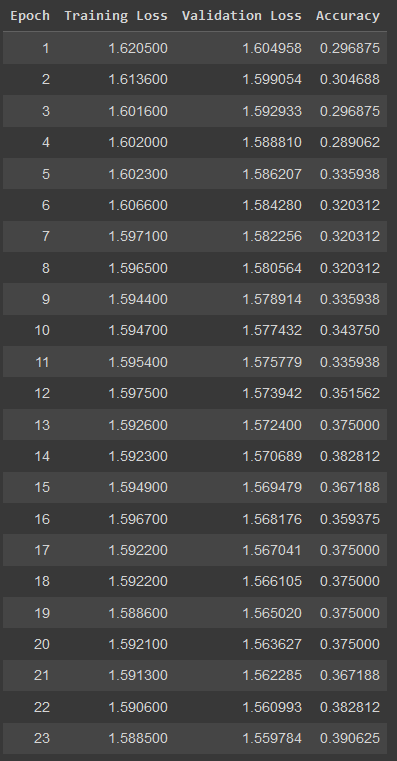

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./content/drive/MyDrive/train_logs/albert-base-v2/

In [ ]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="karimbkh/BERT_fineTuned_Sentiment_Classification_Yelp") # binary output (positive and negative)
# pipe = pipeline(task="text-classification", model="karimbkh/BERT_fineTuned_Sentiment_Classification_Yelp")
# pipe = pipeline(task="sentiment-analysis", model="karimbkh/BERT_fineTuned_Sentiment_Classification_Yelp")
# pipe = pipeline("text-classification", model="overman123/bert-base-cased-finetune-yelp") # not fine-tuned

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
import numpy as np

iii = np.random.randint(0, len(dataset['test']))
print(iii)
print(dataset['test'][iii]['text'])
print('label:', dataset['test'][iii]['label'])
pipe(dataset['test'][iii]['text'])

65
First time at a cicis, not impressed. We paid the extra $8 for their garlic parmasan and buffalo wings...they were not very good, for the quality, they should, have been included in the buffet.  Good place for kids to eat a slice but not much of a selection.
label: 1


[{'label': 'LABEL_0', 'score': 0.8090751767158508}]

In [ ]:
import re
import pandas as pd

n_samples = len(dataset['test'])
out = {'label': np.zeros(n_samples, dtype=float), 'pred': np.zeros(n_samples, dtype=int), 'accurate?': np.zeros(n_samples, dtype=bool), 'score': np.zeros(n_samples)}

for idx in range(n_samples):
    pipe_out = pipe(dataset['test'][idx]['text'], truncation=True)
    if dataset['test'][idx]['label'] == 2:
        out['label'][idx] = 2/4
    else:
        out['label'][idx] = round(dataset['test'][idx]['label']/4,0)

    pred = int(re.sub('LABEL_', '', pipe_out[0]['label']))
    out['pred'][idx] = pred
    out['accurate?'][idx] = (out['label'][idx] == out['pred'][idx])
    out['score'][idx] = pipe_out[0]['score']

out_df = pd.DataFrame(out)
out_df

,label,pred,accurate?,score
0,0.5,1,False,0.993511
1,1.0,1,True,0.995754
2,0.0,0,True,0.995852
3,1.0,1,True,0.994323
4,1.0,1,True,0.982678
...,...,...,...,...
123,0.0,0,True,0.991975
124,0.0,0,True,0.995069
125,0.0,0,True,0.988094
126,1.0,1,True,0.991683


In [ ]:
stop_event.set()

NameError: name 'stop_event' is not defined

In [ ]:
# From ChatGPT
# Not elegant
# Use this just to quickly check GPU usage

import threading
import time
from IPython.display import clear_output, display

# Function to monitor GPU usage
def monitor_gpu():
    while not stop_event.is_set():  # Continue until stopped
        clear_output(wait=True)
        display("Monitoring GPU...")
        !nvidia-smi
        time.sleep(2)  # Update every 2 seconds

# Create an event to signal stopping the monitoring
stop_event = threading.Event()

# Start the GPU monitoring in a separate thread
gpu_monitor_thread = threading.Thread(target=monitor_gpu)
gpu_monitor_thread.start()

# Run your training code
trainer.train()

# Stop the GPU monitoring after training
stop_event.set()
gpu_monitor_thread.join()  # Wait for the thread to finish

'Monitoring GPU...'

Wed Oct  2 16:10:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              68W /  70W |   1519MiB / 15360MiB |    100%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

KeyboardInterrupt: 

In [ ]:
# From ChatGPT - if you want to print the logs but set logging_strategy='no' in TrainingArguments to disable saving to file

class PrintMetricsCallback(TrainerCallback):
    def on_log(self, args, state, control, logs=None, **kwargs):
        print(logs)  # Print metrics when they are logged

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    callbacks=[PrintMetricsCallback()],  # Custom callback to print metrics
)